In [ ]:
import numpy as np
import tensorflow as tf
from numpy import linalg as LA
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as img

mnist = tf.keras.datasets.mnist
(x_train, y_train),(x_test, y_test) = mnist.load_data()

#normalize x, one-hot encoding y shuffle the dataset
x_train = x_train.reshape(x_train.shape[0],x_train.shape[1]**2)
x_train = x_train/255*2-1
Data = np.hstack((x_train,y_train.reshape(x_train.shape[0],1)))
np.random.shuffle(Data)
X = Data[:,:x_train.shape[1]].astype(float)
Y = Data[:,x_train.shape[1]]
X = np.hstack((X,np.ones((X.shape[0],1)))) #append 1 to x, since we need bias
Y_c = np.zeros((Y.shape[0],10))
for i in range(Y.shape[0]):
    Y_c[i,np.int(Y[i])] = 1
Y = Y_c

X_test = x_test/255*2-1
X_test = X_test.reshape(X_test.shape[0],28**2)
X_test = np.hstack((X_test,np.ones((X_test.shape[0],1))))
Y_test = np.zeros((y_test.shape[0],10))
for i in range(y_test.shape[0]):
    Y_test[i,y_test[i]] = 1

#Validation
n = np.int(X.shape[0]*0.9) #number of trainning sample
X_train = X[:n]
Y_train = Y[:n]
X_val = X[n:]
Y_val = Y[n:]

#weight initialization 
hidden = 64
W1 = np.random.normal(0,10**(-3),(hidden,X_train.shape[1]))
W2 = np.random.normal(0,10**(-3),(10,hidden+1))

#learning rate
def LR(lr0,ep,T):
    return lr0/(1+(ep/T))

In [ ]:
epsilon = np.array([10**(-3),10**(-1.5),10**(-1)])

def grad(w2,w1,x,y):
    z1 = w1.dot(x)
    a1 = 1/(1+np.exp(-1*z1))
    a1 = np.vstack((a1,np.ones((1,a1.shape[1]))))
    z2 = w2.dot(a1)
    z2 = z2 - np.max(z2,axis=0)
    a2 = np.exp(z2)
    a2 = a2/np.sum(a2,axis=0)
    #print(z1)
    
    delta2 = a2 - y
    #print('hello')
    delta1 = ( w2.T.dot(delta2) )*((a1)*(1-a1))
    #print('h2')
    return [delta2.dot(a1.T), delta1.dot(x.T)[:hidden]]

def risk(w1,w2,x_train,y_train):
    z1 = w1.dot(x_train)
    a1 = 1/(1+np.exp(-1*z1))
    a1 = np.vstack((a1,np.ones((1,a1.shape[1]))))
    z2 = w2.dot(a1)
    z2 = z2 - np.max(z2,axis=0)
    a2 = np.exp(z2)
    a2 = a2/np.sum(a2,axis=0)
    y=a2
    risk_train = -1*np.sum( np.log(y)*y_train )

    return risk_train

# weights and bias from layer 1
w1_1 = np.zeros(W1.shape)
w1_1[0,406] = 1
w1_2 = np.zeros(W1.shape)
w1_2[1,406] = 1
b1_1 = np.zeros(W1.shape)
b1_1[0,W1.shape[1]-1] = 1
b1_2 = np.zeros(W1.shape)
b1_2[1,W1.shape[1]-1] = 1

# weights and bias from layer 2
w2_1 = np.zeros(W2.shape)
w2_1[0,0] = 1
w2_2 = np.zeros(W2.shape)
w2_2[1,0] = 1
b2_1 = np.zeros(W2.shape)
b2_1[0,W2.shape[1]-1] = 1
b2_2 = np.zeros(W2.shape)
b2_2[1,W2.shape[1]-1] = 1

#array to store numerical gradient
w1_1_arr = np.zeros(epsilon.shape)
w1_2_arr = np.zeros(epsilon.shape)
b1_1_arr = np.zeros(epsilon.shape)
b1_2_arr = np.zeros(epsilon.shape)

w2_1_arr = np.zeros(epsilon.shape)
w2_2_arr = np.zeros(epsilon.shape)
b2_1_arr = np.zeros(epsilon.shape)
b2_2_arr = np.zeros(epsilon.shape)

x = X_train[0].reshape(1,X_train.shape[1])
y = Y_train[0].reshape(1,Y_train.shape[1])
print(x.shape)
print(y.shape)

for i in range(epsilon.shape[0]):
    e = epsilon[i]
    r = risk( (w1_1*e + W1), W2, x.T, y.T ) - risk( (W1 - (w1_1*e)), W2, x.T, y.T )
    w1_1_arr[i] = r/(2*e)
    r = risk( (w1_2*e + W1), W2, x.T, y.T ) - risk( (W1 - (w1_2*e)), W2, x.T, y.T )
    w1_2_arr[i] = r/(2*e)
    r = risk( (b1_1*e + W1), W2, x.T, y.T ) - risk( (W1 - (b1_1*e)), W2, x.T, y.T )
    b1_1_arr[i] = r/(2*e)
    r = risk( (b1_2*e + W1), W2, x.T, y.T ) - risk( (W1 - (b1_2*e)), W2, x.T, y.T )
    b1_2_arr[i] = r/(2*e)
    
    r = risk( W1, (w2_1*e + W2), x.T, y.T ) - risk( W1, (W2 - (w2_1*e)), x.T, y.T )
    w2_1_arr[i] = r/(2*e)
    r = risk( W1, (w2_2*e + W2), x.T, y.T ) - risk( W1, (W2 - (w2_2*e)), x.T, y.T )
    w2_2_arr[i] = r/(2*e)
    r = risk( W1, (b2_1*e + W2), x.T, y.T ) - risk( W1, (W2 - (b2_1*e)), x.T, y.T )
    b2_1_arr[i] = r/(2*e)
    r = risk( W1, (b2_2*e + W2), x.T, y.T ) - risk( W1, (W2 - (b2_2*e)), x.T, y.T )
    b2_2_arr[i] = r/(2*e)

gradient = grad(W2,W1,x.T,y.T)

For first weight in first Layer, backpropagation gradient is 7.847901633024538e-05


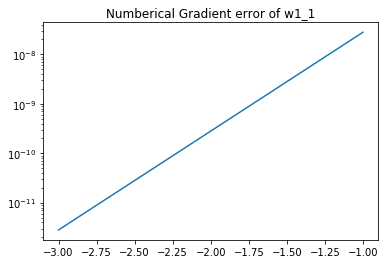

For second weight in first Layer, backpropagation gradient is 3.6424535932920644e-05


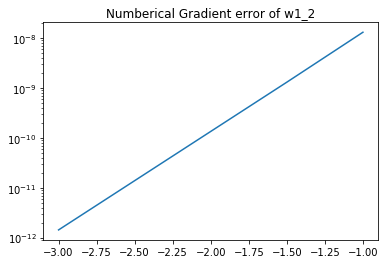

For first bias in first Layer, backpropagation gradient is -0.00011983322852821899


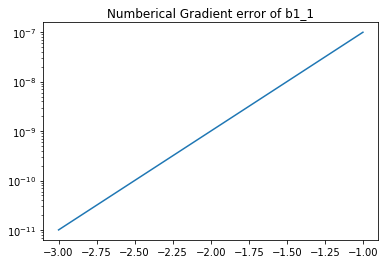

For second bias in first Layer, backpropagation gradient is -5.561830337062733e-05


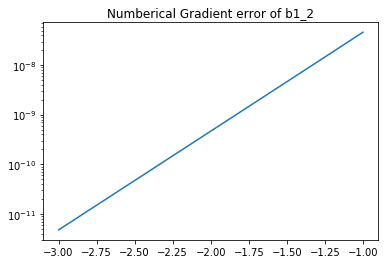

For first weight in second Layer, backpropagation gradient is 0.04931279966446513


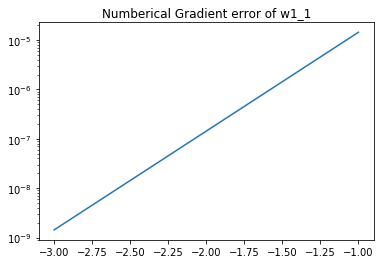

For second weight in second Layer, backpropagation gradient is 0.04899243165449757


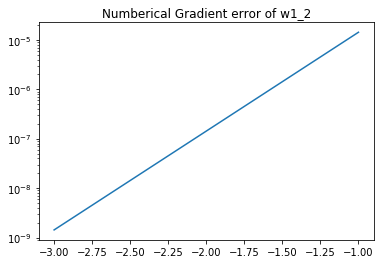

For first bias in second Layer, backpropagation gradient is 0.1001750115564306


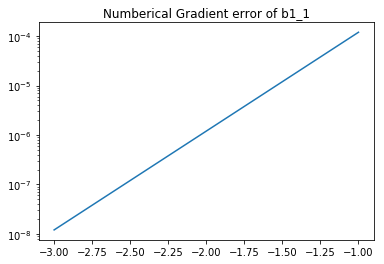

For second bias in second Layer, backpropagation gradient is 0.09952420954723262


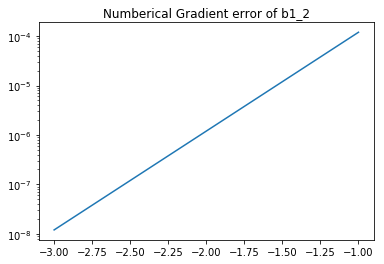

In [3]:
x_axis = np.log10(epsilon)
print("For first weight in first Layer, backpropagation gradient is "+str(np.sum(gradient[1]*w1_1)) )
plt.plot(x_axis,np.absolute(w1_1_arr-np.sum(gradient[1]*w1_1)))
plt.yscale("log")
plt.title('Numberical Gradient error of w1_1')
plt.show()
print("For second weight in first Layer, backpropagation gradient is "+str(np.sum(gradient[1]*w1_2)) )
plt.plot(x_axis,np.absolute(w1_2_arr-np.sum(gradient[1]*w1_2)))
plt.yscale("log")
plt.title('Numberical Gradient error of w1_2')
plt.show()
print("For first bias in first Layer, backpropagation gradient is "+str(np.sum(gradient[1]*b1_1)) )
plt.plot(x_axis,np.absolute(b1_1_arr-np.sum(gradient[1]*b1_1)))
plt.yscale("log")
plt.title('Numberical Gradient error of b1_1')
plt.show()
print("For second bias in first Layer, backpropagation gradient is "+str(np.sum(gradient[1]*b1_2)) )
plt.plot(x_axis,np.absolute(b1_2_arr-np.sum(gradient[1]*b1_2)))
plt.yscale("log")
plt.title('Numberical Gradient error of b1_2')
plt.show()

print("For first weight in second Layer, backpropagation gradient is "+str(np.sum(gradient[0]*w2_1)) )
plt.plot(x_axis,np.absolute(w2_1_arr-np.sum(gradient[0]*w2_1)))
plt.yscale("log")
plt.title('Numberical Gradient error of w1_1')
plt.show()
print("For second weight in second Layer, backpropagation gradient is "+str(np.sum(gradient[0]*w2_2)) )
plt.plot(x_axis,np.absolute(w2_2_arr-np.sum(gradient[0]*w2_2)))
plt.yscale("log")
plt.title('Numberical Gradient error of w1_2')
plt.show()
print("For first bias in second Layer, backpropagation gradient is "+str(np.sum(gradient[0]*b2_1)) )
plt.plot(x_axis,np.absolute(b2_1_arr-np.sum(gradient[0]*b2_1)))
plt.yscale("log")
plt.title('Numberical Gradient error of b1_1')
plt.show()
print("For second bias in second Layer, backpropagation gradient is "+str(np.sum(gradient[0]*b2_2)) )
plt.plot(x_axis,np.absolute(b2_2_arr-np.sum(gradient[0]*b2_2)))
plt.yscale("log")
plt.title('Numberical Gradient error of b1_2')
plt.show()

Salient aspects of the training procedure: SDG generally converges. There are small flunctuations in the risk and accuracy plot. <br> <br>
The network is not necessarily improving over each iteration or epoch of SDG. As we inspect the risk and accuracy over epoch plot, we can see some spikes at some epoch, which means that the accuracy decreases at these epochs. However, although SDG does not necessary improve at each iteration and epoch, by experiments, SDG does improve and converge generally, and usually even converges faster than full-batch gradient descent because of the randomness SDG introduces to the training. <br> <br>
Another finding from the results is that: with one more hidden layer and non-linear activation function, the accuracy and risk of this network have improved over the single layer network from previous HW. 

In [ ]:
lr0 = 10**(-2)
T = 8
itr = 64
batch = 128
epsilon = []

# This function returns gradient. x_i are columns of x. y_i are columns of y
def grad(w2,w1,x,y):
    z1 = w1.dot(x)
    a1 = 1/(1+np.exp(-1*z1))
    a1 = np.vstack((a1,np.ones((1,a1.shape[1]))))
    z2 = w2.dot(a1)
    z2 = z2 - np.max(z2,axis=0)
    a2 = np.exp(z2)
    a2 = a2/np.sum(a2,axis=0)
    #print(z1)
    
    delta2 = a2 - y
    #print('hello')
    delta1 = ( w2.T.dot(delta2) )*((a1)*(1-a1))
    #print('h2')
    return [delta2.dot(a1.T), delta1.dot(x.T)[:hidden]]

# Return train and val acc & rick
def get_acc_risk(w2,w1,x_train,y_train,x_val,y_val):
    z1 = w1.dot(x_train)
    a1 = 1/(1+np.exp(-1*z1))
    a1 = np.vstack((a1,np.ones((1,a1.shape[1]))))
    z2 = w2.dot(a1)
    z2 = z2 - np.max(z2,axis=0)
    a2 = np.exp(z2)
    a2 = a2/np.sum(a2,axis=0)
    y=a2
    risk_train = -1*np.sum( np.log(y)*y_train )
    correct = 0
    for i in range(x_train.shape[1]):
        if np.argmax(y[:,i]) == np.argmax(y_train[:,i]):
            correct = correct+1
    train = correct/(y_train.shape[1])
    
    
    z1 = w1.dot(x_val)
    a1 = 1/(1+np.exp(-1*z1))
    a1 = np.vstack((a1,np.ones((1,a1.shape[1]))))
    z2 = w2.dot(a1)
    z2 = z2 - np.max(z2,axis=0)
    a2 = np.exp(z2)
    a2 = a2/np.sum(a2,axis=0)
    y=a2
    
    risk_val = -1*np.sum( np.log(y)*y_val )
    correct = 0
    for i in range(x_val.shape[1]):
        if np.argmax(y[:,i]) == np.argmax(y_val[:,i]):
            correct = correct+1
    val = correct/(y_val.shape[1])
    return np.array([train,val,risk_train,risk_val])

acc_val = np.zeros((itr,))
acc_train = np.zeros((itr,))
risk_val = np.zeros((itr,))
risk_train = np.zeros((itr,))


#start batched learning
combined = np.hstack((X_train,Y_train))
print(Y_train.shape)
print(combined.shape)
for ep in range(itr):
    np.random.shuffle(combined)
    X = combined[:,:X_train.shape[1]]
    Y = combined[:,X_train.shape[1]:]
    print(ep)
    
    for j in range(np.int(X_train.shape[0]/batch)):
        x = X[j*batch:j*batch+batch]
        y = Y[j*batch:j*batch+batch]
        lr = LR(lr0,ep,T)
        gradient = grad(W2,W1,x.T,y.T)
        W2 = W2 - lr*gradient[0]
        W1 = W1 - lr*gradient[1]
    [acc_train[ep],acc_val[ep],risk_train[ep],risk_val[ep]] = get_acc_risk(W2,W1,X_train.T,Y_train.T,X_val.T,Y_val.T)

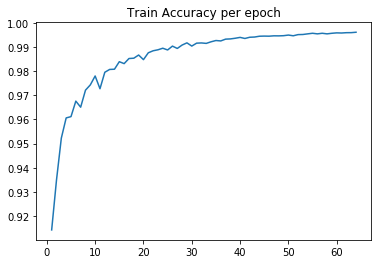

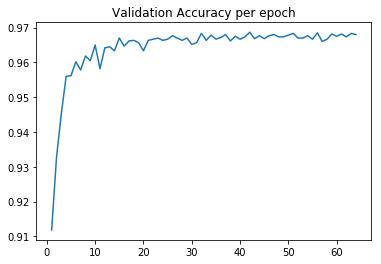

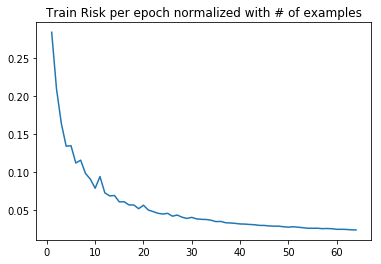

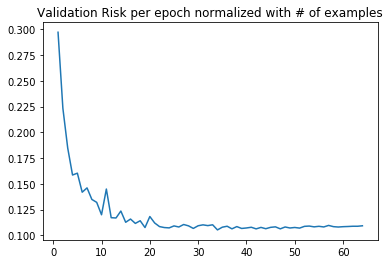

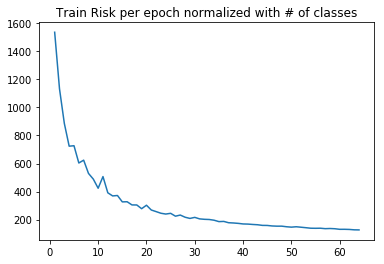

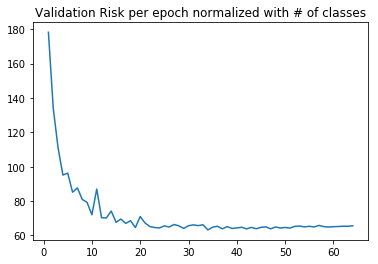

Final training accuracy is 0.9960925925925926
Final validation accuracy is 0.968
Test set accuracy is 0.9697


In [12]:
x_axis = np.arange(itr)+1
plt.plot(x_axis,acc_train)
plt.title('Train Accuracy per epoch')
plt.show()
plt.plot(x_axis,acc_val)
plt.title('Validation Accuracy per epoch')
plt.show()

plt.plot(x_axis,risk_train/X_train.shape[0])
plt.title('Train Risk per epoch normalized with # of examples')
plt.show()
plt.plot(x_axis,risk_val/X_val.shape[0])
plt.title('Validation Risk per epoch normalized with # of examples')
plt.show()

plt.plot(x_axis,risk_train/10)
plt.title('Train Risk per epoch normalized with # of classes')
plt.show()
plt.plot(x_axis,risk_val/10)
plt.title('Validation Risk per epoch normalized with # of classes')
plt.show()

print('Final training accuracy is '+str(acc_train[itr-1]))
print('Final validation accuracy is '+str(acc_val[itr-1]))
print('Test set accuracy is '+ str( get_acc_risk(W2,W1,X_test.T,Y_test.T,X_val.T,Y_val.T)[0] ))